# Development of polymer building, including monomer and bonding spec

In [1]:
from rdkit import Chem
from rdkit.Chem import RWMol, BondType

from polysaccharide2 import rdutils
from polysaccharide2.rdutils import rdkdraw
from polysaccharide2.rdutils.rdtypes import RDAtom, RDBond, RDMol
from polysaccharide2.rdutils.labeling import atomwise, molwise
from polysaccharide2.rdutils.labeling.molwise import assign_ordered_atom_map_nums
from polysaccharide2.rdutils.amalgamation import bonding, portlib

from polysaccharide2.genutils.iteration import iter_len
from polysaccharide2.genutils.decorators.functional import optional_in_place

/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from .xtc import XTCTrajectoryFile
/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/mdtraj/geometry/order.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/pkg_resources/__init__

# Port-binding rules

## Test structures

In [2]:
# some "normal" molecules for testing
H  = Chem.MolFromSmarts('[#1]-[1#0]')
OH = Chem.MolFromSmarts('[#1]-[O]-[2#0]')
METHYL = Chem.MolFromSmarts('[#6](-[2#0])(-[2#0])(-[3#0])(-[1#0])')
CARBONYL = Chem.MolFromSmarts('[#6]-[#6](=[#8])-[1#0]')
WITTIG = Chem.MolFromSmarts('[#6](=[1#0])(-[2#0])(-[#1])')
WITTIG_DUAL = Chem.MolFromSmarts('[#6](=[1#0])(-[#7](-[#1])(-[#1]))(-[#1])')

TEST_MOLS_NORMAL = (
    H,
    OH,
    METHYL,
    WITTIG,
    WITTIG_DUAL,
    CARBONYL
)

# Pathological examples for debug
DOUBLE_MID = Chem.MolFromSmarts('[#6](-[1#0])(-[#1])=[#0]-[#6](-[#1])(-[#1])(-[2#0])')
NEUTRONIUM = Chem.MolFromSmarts('[#0]-[#0]')
GHOST_WATER = Chem.MolFromSmarts('[#1]-[#0]-[#1]')

TEST_MOLS_PATHO = (
    DOUBLE_MID,
    NEUTRONIUM,
    GHOST_WATER
)

# COMBINE FOR UNIVERSAL TESTING
TEST_MOLS = (
    *TEST_MOLS_NORMAL,
    *TEST_MOLS_PATHO
)

1


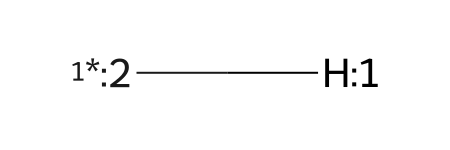

1


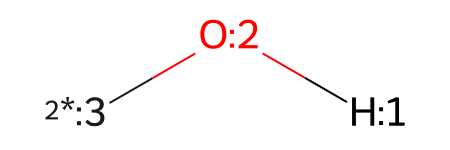

4


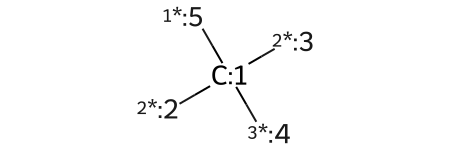

2


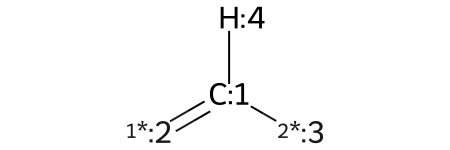

1


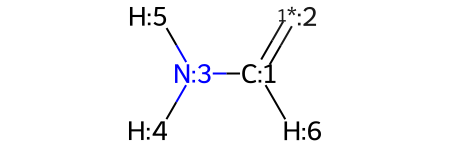

1


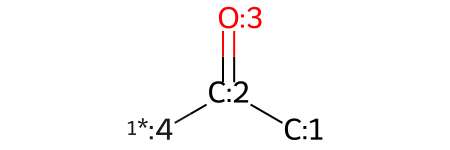

2


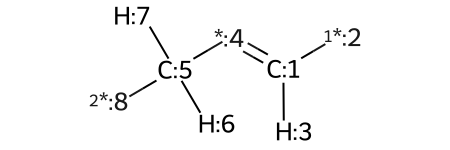

0


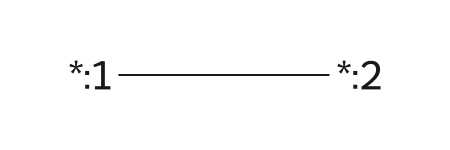

0


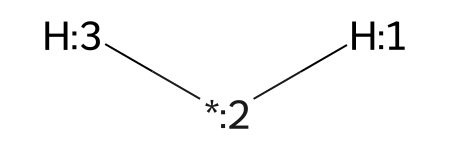

In [3]:
rdkdraw.disable_substruct_highlights()

for mol in TEST_MOLS:
    assign_ordered_atom_map_nums(mol, in_place=True)
    print(portlib.get_num_ports(mol))
    display(mol)

## Testing bond dissolution and splicing 

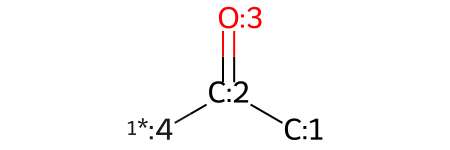

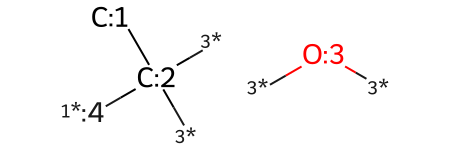

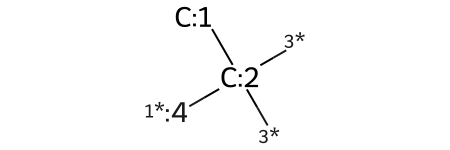

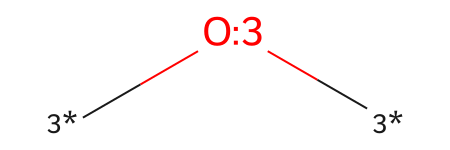

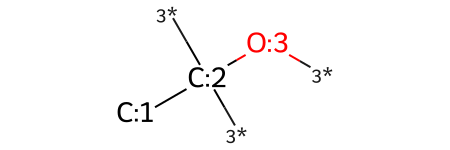

In [4]:
a1 = 2 - 1 # indices of atoms to target
a2 = 3 - 1 # indices of atoms to target
flavor_pair = (1, 3) # pair of port flavors to interface together

display(CARBONYL)
frags = bonding.dissolve_bond(Chem.RWMol(CARBONYL), a1, a2, new_port_flavor=3)
MET, OXY = Chem.GetMolFrags(frags, asMols=True, sanitizeFrags=True)

display(frags)
display(MET)
display(OXY)

portlib.Port.bondable_flavors.insert(flavor_pair)
bondable_pair = portlib.get_first_bondable_port_pair(frags, a1, a2, flavor_pair=flavor_pair)
prod1 = bonding.splice_atoms(frags, 1, 2, flavor_pair=(1,3), in_place=False)
display(prod1)

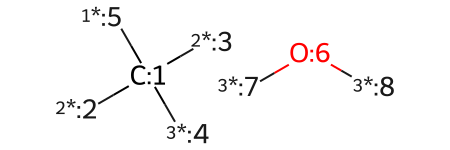

1


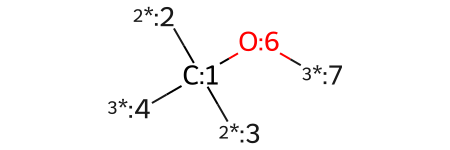

In [5]:
TEST = bonding.combined_rdmol(METHYL, OXY)
display(TEST)

order2 = portlib.max_bondable_order_between_atoms(TEST, 0, 5, target_flavor=3)
prod2 = bonding.splice_atoms(TEST, 0, 5, flavor_pair=(1,3))

print(order2)
display(prod2)

## Testing port saturation

### Testing single bonds

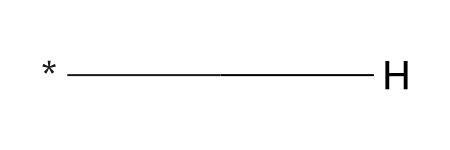

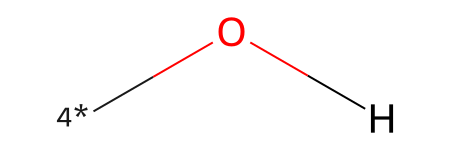

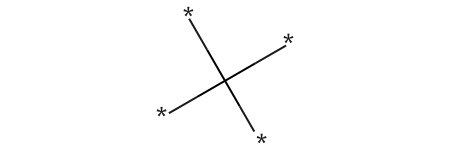

In [6]:
H_GENERIC = Chem.MolFromSmarts('[#1]-[#0]')
OH_GENERIC = Chem.MolFromSmarts('[#1]-[O]-[4#0]')
METHYL_GENERIC = Chem.MolFromSmarts('[#6](-[#0])(-[#0])(-[#0])(-[#0])')

display(H_GENERIC)
display(OH_GENERIC)
display(METHYL_GENERIC)

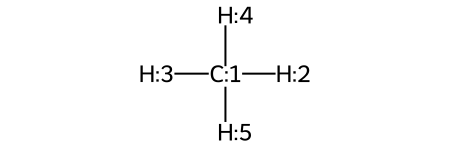

In [7]:
bonding.saturate_ports(METHYL_GENERIC, H_GENERIC)

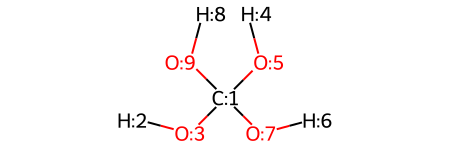

In [8]:
portlib.Port.bondable_flavors.insert((0,4))
bonding.saturate_ports(METHYL_GENERIC, OH_GENERIC)

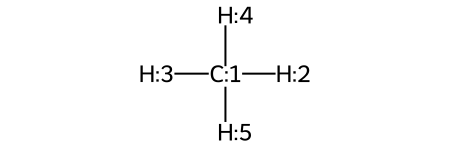

In [9]:
bonding.saturate_ports(METHYL_GENERIC, H_GENERIC)

### Testing double bonds

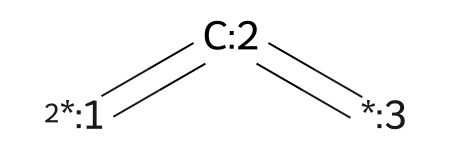

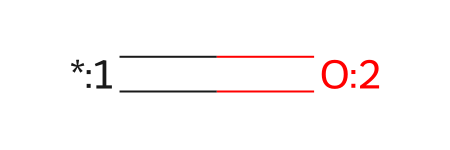

In [11]:
CARBENE = Chem.MolFromSmarts('[2#0:1]=[#6:2]=[#0:3]')
DIOX    = Chem.MolFromSmarts('[#0:1]=[#8:2]')

display(CARBENE)
display(DIOX)

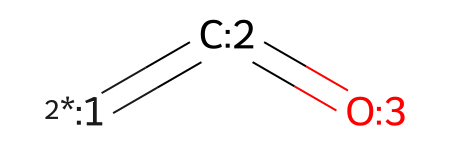

In [12]:
bonding.saturate_ports(CARBENE, cap=DIOX, flavor_to_saturate=2)

### Testing selectivity between mixed single and double bonds

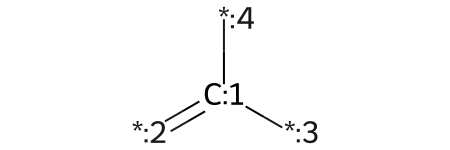

In [13]:
C3 = Chem.MolFromSmarts('[#6:1](=[#0:2])(-[#0:3])(-[#0:4])')
C3

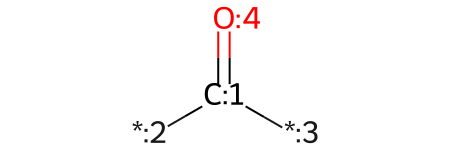

In [14]:
bonding.saturate_ports(C3, cap=DIOX)

### Testing the null case (no bonds formable, but with flavors matching)

# Implementing monomer-spec SMARTS query assignment

In [ ]:
from polysaccharide2.rdutils.rdtypes import RDAtom, RDMol

def _get_compliant_atom_query(rdatom : RDAtom) -> Chem.QueryAtom:
    '''Generated monomer-specification-compliant atom query SMARTS string (<insert our citation eventually>) for a non-port atom'''
    assert(rdatom.GetAtomicNum() != 0) # TODO : add special case for handling ports once port spec is solidified

    isotope      = rdatom.GetIsotope()
    atomic_num   = rdatom.GetAtomicNum()
    degree_num   = rdatom.GetDegree() # counts number of active bonds
    formal_chg   = rdatom.GetFormalCharge()
    atom_map_num = rdatom.GetAtomMapNum() # TODO : add check for nonzero map num   
    
    if isotope == 0:
        query_SMARTS = f'[#{atomic_num}D{degree_num}{formal_chg:+}:{atom_map_num}]'
    else:
        query_SMARTS = f'[{isotope}?#{atomic_num}D{degree_num}{formal_chg:+}:{atom_map_num}]'
    print(query_SMARTS)

    return Chem.AtomFromSmarts(query_SMARTS) # include explicit plus for positive formal charges

In [ ]:
PVC_SMARTS = "[1#0:7]-[#6D4+0:1](-[#1D1+0:2])(-[#1D1+0:3])-[#6D4+0:4](-[#17D1+0:5])(-[#1D1+0:6])-[2#0:14]"
PVC = Chem.MolFromSmarts(PVC_SMARTS)
PVC

In [ ]:
import re

MONOMER_ATOM_QUERY = re.compile(
    r'\[(?P<isotope>\d?)' \
    r'#(?P<atomic_num>\d+?)' \
    r'(?P<valence>.*?)' \
    r':(?P<map_num>\d+?)\]'
)

DEGREE_CHARGE_QUERY = re.compile(
    r'D(?P<degree>\d{1})' \
    r'[+-](?P<formal_charge>\d+)'
)

In [ ]:
for match in re.finditer(MONOMER_ATOM_QUERY, PVC_SMARTS):
    groups = match.groupdict()

    if groups.get('isotope') == '':
        groups['isotope'] = '0'

    if (valence := groups.get('valence')):
        atom_info = re.search(DEGREE_CHARGE_QUERY, valence).groupdict()
        groups.update(atom_info)
    groups.pop('valence') # discard for both linkers and non-linkers
    groups = {
        key : int(val)
            for key, val in groups.items() # convert to ints from strings
    }

    print(groups)

In [ ]:
METHYL = Chem.MolFromSmarts('[#6D4+0](-[3#0])(-[2#0])(-[4#0])(-[1#0])')
display(METHYL)
print(Chem.MolToSmiles(METHYL))
print(Chem.MolToSmarts(METHYL))

In [ ]:
mol = METHYL

for atom in mol.GetAtoms():
    if iter_len(portlib.get_ports_on_atom_at_idx(mol, atom.GetIdx())) == 0:
        if atom.GetSymbol() == 'O':
            atom.SetIsotope(1)
        query_atom = _get_compliant_atom_query(atom)
        atom.SetQuery(query_atom)
        # print(_get_compliant_atom_query(atom))

display(mol)
print('RDKit-generated mol query : ', Chem.MolToSmarts(mol), Chem.MolToSmiles(mol))

In [ ]:
for atom in mol.GetAtoms():
    print(atom.GetSmarts())

In [ ]:
Chem.MolFromSmiles('[#6&D4&+0:1](-[#0&2*:2])(-[#0&2*:3])(-[#0&2*:4])-[#0&1*:5]')

In [ ]:
sm = Chem.MolToSmarts(mol)
sm = sm.replace('&', '')

mol2 = Chem.MolFromSmarts(sm)
display(mol2)

In [ ]:
block = Chem.MolToMolBlock(mol)

In [ ]:
import pandas as pd
from polysaccharide2.genutils.iteration import iter_len

records = []
for atom in mol.GetAtoms():
    record = {
        'symbol' : atom.GetSymbol(),
        'map num' : atom.GetAtomMapNum(),
        'num bonds' : iter_len(atom.GetBonds()),
        'impl_valence' : atom.GetImplicitValence(),
        'expl_valence' : atom.GetExplicitValence(),
        'total_valence' : atom.GetTotalValence(),
    }
    records.append(record)
df = pd.DataFrame.from_records(records)
df

In [ ]:
s = '[#6D4+0:1](-[5#02*:3])(-[2#8D2+0:5]-[#1D1+0:4])(-[#8D2+0:7]-[#1D1+0:6])-[#8D2+0:9]-[#1D1+0:8]'
mol3 = Chem.MolFromSmarts(s)
display(mol3)
print(s)
print(Chem.MolToSmarts(mol3))